In [1]:
import pandas as pd
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from pyRothC.RothC import RothC
np.set_printoptions(precision=3,suppress=True )

## RothC 

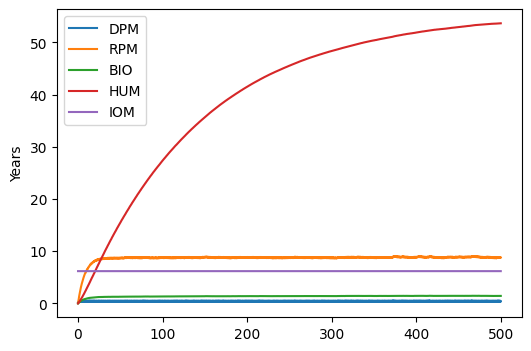

In [2]:
Temp=np.array([-0.4, 0.3, 4.2, 8.3, 13.0, 15.9,18.0, 17.5, 13.4, 8.7, 3.9,  0.6])
Precip=np.array([49, 39, 44, 41, 61, 58, 71, 58, 51,48, 50, 58])
Evp=np.array([12, 18, 35, 58, 82, 90, 97, 84, 54, 31,14, 10])

soil_thick=25  #Soil thickness (organic layer topsoil), in cm
SOC=69.7       #Soil organic carbon in Mg/ha 
clay=48        #Percent clay
input_carbon=2.7   #Annual C inputs to soil in Mg/ha/yr

IOM=0.049*SOC**(1.139) # Falloon et al. (1998)


rothC = RothC(temperature=Temp, 
             precip=Precip, 
             evaporation=Evp,
             clay = 48,
             years=500, 
             input_carbon=input_carbon,
             pE=1.0,
             C0=np.array([0, 0, 0, 0, IOM]))

df = rothC.compute()
df.index = rothC.t
fig, ax = plt.subplots(1,1,figsize=(6,4))
df.plot(ax=ax)
ax.set_ylabel('C stocks (Mg/ha)')
ax.set_ylabel('Years')
plt.show()

## Pedotranser functions for initial soil conditions

----

Paper: [Weihermueller et al. (2013)](https://bsssjournals.onlinelibrary.wiley.com/doi/pdf/10.1111/ejss.12036?casa_token=_IP4YS2QpN0AAAAA:GTB174qCuWQlDN_5IfvM_j43agtnlIcn4C2i4uG5tsKDZqnksafuCaOywdCfUh_YmI-7xljoCElLkwGqKA)

In [3]:
RPMptf=(0.184*SOC + 0.1555)*(clay + 1.275)**(-0.1158)
HUMptf=(0.7148*SOC + 0.5069)*(clay + 0.3421)**(0.0184)
BIOptf=(0.014*SOC + 0.0075)*(clay + 8.8473)**(0.0567)

DPMptf=SOC-IOM-RPMptf-HUMptf-BIOptf

C0=np.array([DPMptf, RPMptf, BIOptf, HUMptf, IOM])

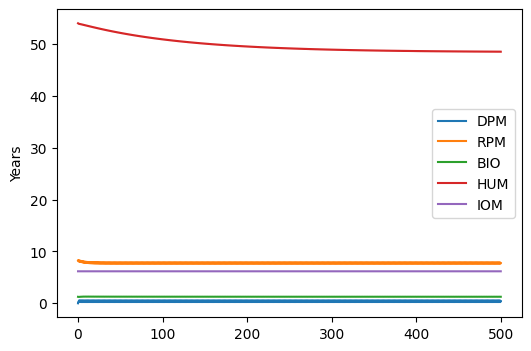

In [7]:
rothC = RothC(temperature=Temp, 
             precip=Precip, 
             evaporation=Evp,
             clay = 48,
             input_carbon=input_carbon,
             pE=1.0,
             bare=np.zeros(12),
             C0=C0)

df = rothC.compute()
df.index = rothC.t
fig, ax = plt.subplots(1,1,figsize=(6,4))
df.plot(ax=ax)
ax.set_ylabel('C stocks (Mg/ha)')
ax.set_ylabel('Years')
plt.show()

## Soil vegetation, input carbon and manure for each month
----


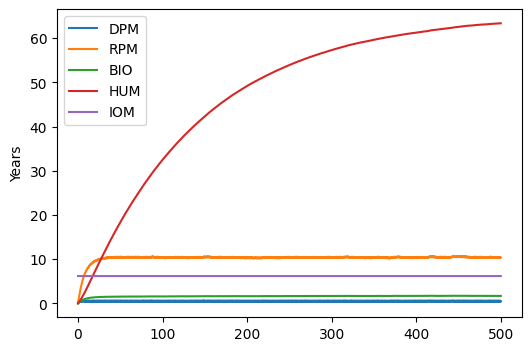

In [7]:
Temp=np.array([-0.4, 0.3, 4.2, 8.3, 13.0, 15.9,18.0, 17.5, 13.4, 8.7, 3.9,  0.6])
Precip=np.array([49, 39, 44, 41, 61, 58, 71, 58, 51,48, 50, 58])
Evp=np.array([12, 18, 35, 58, 82, 90, 97, 84, 54, 31,14, 10])

soil_thick=25  #Soil thickness (organic layer topsoil), in cm
SOC=69.7       #Soil organic carbon in Mg/ha 
clay=48        #Percent clay
#Annual C inputs to soil in Mg/ha/yr
input_carbon=np.array([0,0,0, 0.2, 0.4, 0.5, 0.2, 0.4, 1.5,0,0,0])   
soil_bare = np.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0])

IOM=0.049*SOC**(1.139) # Falloon et al. (1998)


rothC = RothC(temperature=Temp, 
             precip=Precip, 
             evaporation=Evp,
             clay = 48,
             years=500, 
             input_carbon=input_carbon,
             pE=1.0,
             bare=soil_bare, 
             C0=np.array([0, 0, 0, 0, IOM]))

df = rothC.compute()
df.index = rothC.t
fig, ax = plt.subplots(1,1,figsize=(6,4))
df.plot(ax=ax)
ax.set_ylabel('C stocks (Mg/ha)')
ax.set_ylabel('Years')
plt.show()

## End